# FAST: An Adaptive Group Testing Strategy

Here we give simple examples of creating and evaluating group
testing strategies. In our case, we evaluate strategies:

- individual testing; 
- one-layer random grouping (Dorfman's method);
- two-layer random grouping; 
- one-layer correlated grouping; 
- FAST.


# 0 Global Settings and Imports

In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm
from utils import batch, flatten
from utils.plots import plot_scatter_line
from simulation import SampleGenerator
from grouptesting import Algorithm
import matplotlib.pyplot as plt

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))

System version: 3.7.5 (default, Oct 25 2019, 10:52:18) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version: 0.25.3
Numpy version: 1.17.4


# 1 Generate Simulation Data
We generate hierarchical data containing infected patients
and healthy ones. The data is generated as 2-D nested lists, meaning
naturally grouped people(e.g. by family). 1 means infected, 0 means healthy

Example:

In [2]:
x=[[1,0,0],[0,0],[0],[0,0,1,0]]

### 1.1 Parameters
paras_sample controls the simulation set-up, paras_test controls the noisy test

- 'size': number of sub-pools
- 'rho': overall prevalence
- 'sub_pool': distribution of natural sub-pool sizes, such as family sizes
- 'fnr','fpr': false negative\postive rate
- 'dilution factor': default is 0, whether to add dilution factor.

In [3]:
np.random.seed(0)

paras_sample = {
    'size': 5000,
    'rho': 0.01,
    'sub_pool': ([1, 2, 3, 4, 5, 6, 7], [0.28, 0.35, 0.15, 0.13, 0.06, 0.02, 0.01]),  # ([3], [1]),
    'beta': 0.5,
}

paras_test = {
    'fnr': 0.02,
    'fpr': 0.001,
    'dilution_factor': 0.0
}

### 1.2 Generate samples

In [4]:
sample = SampleGenerator(paras_sample)

SampleGenerator.generate_unit() gives 1-D list, which dose not use sub-pool
information

In [5]:
x = sample.generate_unit()
print(x[:10])
print('size={}'.format(len(x)))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
size=5000


SampleGenerator.generate_fam_sample() gives nested list by creating
sub-pools by distribution of sizes.

In [6]:
x = sample.generate_fam_sample()
print(x[:10])
print('size={}'.format(len(x)))

[[0, 0], [0, 0], [0], [0, 0, 0, 0, 0], [0, 0], [0, 0, 0, 0], [0, 0, 0], [0, 0], [0, 0, 0, 0], [0, 0]]
size=5000


# 2 Design group testing strategies
The basic idea to program group testing strategies is to reform the dataset
as a specific nested list. The tree structure of a nested list naturally defines
the procedure of group testing. To test each layer of the list, we pass the data into
'Algorithm.layer' function. To specify number of test replicates and whether to apply
once-positive rule or majority rule, we use r and op to control the settings:

In [7]:
# r=[num_replicates_1_layer_test, num_replicates_2_layer_test,...]
# op: 1 means once-positive rule, 0 means majority rule
r=[2,2,2],
op = [1,1,0]

Define subclass of 'Algorithm' to design strategy. The 'strategy' method
must be overrode each time. Use function 'flatten' to flat a nested list if necessary

In our design, we apply repetition test and once-positive rule(2 in 'r' and 1 in 'op').

- Individual test(benchmark):

In [8]:
class Individual(Algorithm):
    def __init__(self, **paras):
        super(Individual, self).__init__(**paras)

    def strategy(self, x):
        return self.layer(flatten(x), r=[1, 1], op=[0, 0])

- one-layer random grouping (Dorfman's method)

In [9]:
class RG1(Algorithm):
    def __init__(self, **paras):
        super(RG1, self).__init__(**paras)

    def strategy(self, x, k):
        flat_x = flatten(x)
        self.flat_x, flat_x = shuffle(self.flat_x, flat_x)
        pooling = batch(flat_x, k)
        return self.layer(pooling, r=[2, 2], op=[1, 1])

- one-layer correlated grouping

In [10]:
class CG1(Algorithm):
    def __init__(self, **paras):
        super(CG1, self).__init__(**paras)
# k_star: number of families
    def strategy(self, x, k_star):
        pooling = batch(x, k_star)
        pooling = [flatten(i) for i in pooling]
        return self.layer(pooling, r=[2, 2], op=[1, 1])

- two-layer random grouping

In [11]:
# m: size of subpool
class RG2(Algorithm):
    def __init__(self, **paras):
        super(RG2, self).__init__(**paras)

    def strategy(self, x, k, m):
        flat_x = flatten(self.x)
        self.flat_x, flat_x = shuffle(self.flat_x, flat_x)
        k_star = int(max(round(k / m), 1))
        pooling = batch(flat_x, m)
        pooling = batch(pooling, k_star)
        return self.layer(pooling, r=[2, 2, 2], op=[1, 1, 1])


- FAST

In [12]:
class FAST(Algorithm):
    def __init__(self, **paras):
        super(FAST, self).__init__(**paras)

    def strategy(self, x, k_star):
        pooling = batch(x, k_star)
        return self.layer(pooling, r=[2, 2, 2], op=[1, 1, 1])

# 3 Performance
For example ,we choose FAST with each pool of 10 families and two-layer random grouping with
each pool of 10 sub-pools and each sub-pool contains 3 individuals.

In [13]:
# Results are given by lists
group_testing_fast = FAST(**paras_test)
group_testing_rg2 = RG2(**paras_test)
y_fast, ppt_fast = group_testing_fast(x,10)
y_rg2, ppt_rg2 = group_testing_rg2(x,10,3)
print("FAST:")
print("Persons-Per-Test: {}".format(ppt_fast))
print("Two layer random grouping:")
print("Persons-Per-Test: {}".format(ppt_rg2))

FAST:
Persons-Per-Test: 4.649270913277053
Two layer random grouping:
Persons-Per-Test: 2.9608993157380255


Accuracies

In [14]:
fnr_fast, fpr_fast = group_testing_fast.accuracy
fnr_rg2, fpr_rg2 = group_testing_rg2.accuracy
print("FAST: FNR={}, FPR={}".format(fnr_fast, fpr_fast))
print("Two layer random grouping: FNR={}, FPR={}".format(fnr_rg2, fpr_rg2))


FAST: FNR=0.0, FPR=0.0
Two layer random grouping: FNR=0.0, FPR=8.336112037345781e-05


# 4 Theoretical Plots

Get some plot functions

In [15]:
from utils.plots import *

plots Persons-Per-Test corresponding to different prevalence
$\rho$ and pooling size $k$, which suggests to find optimal pooling size.
The following gives an example for one-layer random group testing

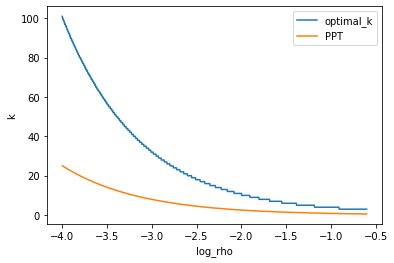

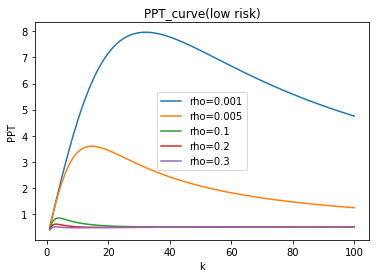

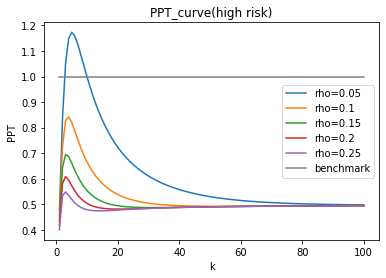

In [16]:
opt_k()

Or surface

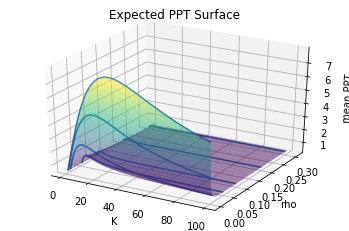

In [17]:
ppt_surface()